### 📈REPLICATING AND TESTING CUSTOM MAXOUT NETWORKS.

Hey there! This notebook is meant to compare the performance of two MLP models with different activation functions on the MNIST dataset. 
The first of these uses the typical ReLU activation, while the second uses **a custom maxout activation function** (replicating the original 2013 paper https://arxiv.org/abs/1302.4389) as defined in **Maxout.py**.

The objective of this experiment is to see whether the theoretical benefits of Maxout work in real-world use cases. As outlined in the above paper, Maxout can (arbitrarily) approximate any continuous function as it acts much like a piecewise linear approximator - this is promising, as it means that both the ReLU and Leaky ReLU activation functions are both special cases of Maxout. Logically, this should mean that maxout can learn more complex functions and thus be able to better model an existing relationship.

Practically, the function works by splitting the input vector into *i* groups of *k* neurons each. Then, it takes the **MAXIMUM** for each one of these groups - turning the group of *k* neurons into just one. So, if there are 10 neurons in total, and we split the layer into groups of 2 ($i=2$, $k=5$), then that means that activation function will map those 10 neurons **to just 2** - taking the **highest activations and capturing the relationships that appear to have the most relevance**.

This essentially means that **maxout also has its own weights as it acts much like a linear transform* - this produces more trainable parameters but also offers the opportunity for better learning.

**Mathematically:**
$h_1(x)=max_{jΣ[1, k]}z_{ij}$, where $z_{ij}=x^TW_{...ij}+b_{ij}$

**Visually:** (credit to @MlforNerds https://www.youtube.com/watch?v=DTVlyP-VihU&t=403s):

<img src="./images/MAXOUT_DIAGRAM_MLFORNERDS.jpg" alt="Maxout Diagram" />


### 📝METHODOLOGY
Both models will be trained on Hadnwritten digit classification via MNIST (344k samples). 

The ReLU model will be trained via FastAI, whereas the Maxout model will use FastAI *Dataloaders* and *Learners* but PyTorch for the training loop (as the activation function has been implemented seperately). In the end, **both models are tested on the same 8 000 samples** and accuracy + confusion matricies are reported.

Feel free to clone this repo and try it out for yourself! Reach out to aditya.dewan124@gmail.com, @adidewan124 on Twitter, or via LinkedIn if you have any questions or ideas.

*Special thanks to Ian Goodfellow, David Warde-Farley, Mehdi Mirza, Aaron Courville, and Yoshua Bengio for coming up with the original concept back in 2013! Check out their paper here https://arxiv.org/abs/1302.4389*

In [ ]:
#For datablocks and data processing + training
import fastai
print(fastai.__version__)
from fastai.vision.all import *
#For neural networks
import torch.nn as nn
#For activation functions and layers
import torch.nn.functional as F
#Import pandas and numpy
import pandas as pd
import numpy as np

In [2]:
#Import handwritten digit classification dataset via untar_data
#Use a small subset of the MNISt dataset (344k samples)
dataset = untar_data(URLs.MNIST)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
torch.Size([64, 3, 28, 28])
torch.Size([64])


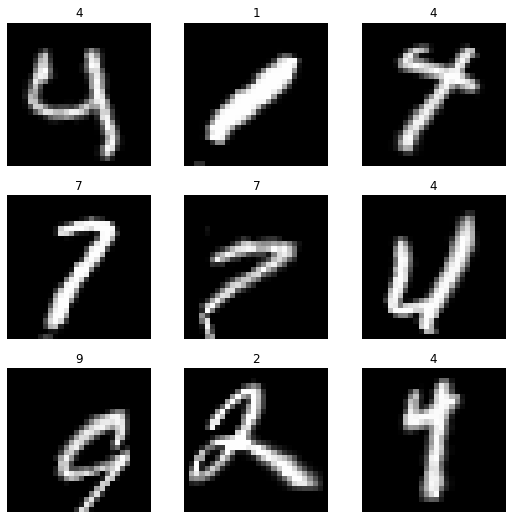

In [4]:
#Create a new datablock object (tells us preconditions for processing data)
#We pass in the respective data to the block for processing
datablock = DataBlock(
            blocks = (ImageBlock, CategoryBlock),
            get_items = get_image_files,
            splitter = RandomSplitter(valid_pct = 0.2, seed = 32),
            get_y = parent_label,
            batch_tfms = aug_transforms(mult = 2.0, do_flip = False))

#Create a data loader and pass in the training path -> will apply transforms and apply labels based on directories
batch_size = 64
training_dataloader = datablock.dataloaders(dataset/"training", batch_size = batch_size)
training_dataloader.train.show_batch()
sample_batch = training_dataloader.train.one_batch()

print(sample_batch[0].shape)
print(sample_batch[1].shape)

TRAINING RELU MODEL

In [11]:
#Create a ReLU and custom Maxout model and compare performance
#We have three channels in our data - they are identical as the image is black and white
n_channels = 3

#ReLU Model (ReLU is a special case of Maxout with k = 2)
ReLUModel = nn.Sequential(
    #Flatten inputs
    nn.Flatten(),
    #Basic Linear transform - shape of input images is 28*28 and has 3 channels; thus first input will have 28*28*3 samples
    nn.Linear(28*28*n_channels, 500),
    nn.ReLU(),
    nn.Linear(500, 300),
    nn.ReLU(),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    #Use log softmax over softmax as gradient is easier to compute -> very close to the line x - max(x)
    nn.LogSoftmax(dim=1)
)

#Custom maxout model
from Maxout import CustomMaxout

#Keep everything the same but add maxout activations
CustomMaxoutModel = nn.Sequential(
    #Flatten inputs
    nn.Flatten(),
    #Basic Linear transform - shape of input images is 28*28
    nn.Linear(28*28*n_channels, 500),
    #nn.ReLU(),
    CustomMaxout(500, 400, n_channels, False),
    nn.Linear(400, 300),
    #nn.ReLU(),
    CustomMaxout(300, 200, n_channels, False),
    nn.Linear(200, 100),
    #nn.ReLU(),
    CustomMaxout(100, 50, n_channels, False),
    nn.Linear(50, 10),
    #Use log softmax over softmax as gradient is easier to compute -> very close to the line x - max(x)
    nn.LogSoftmax(dim=1)
)

SuggestedLRs(valley=0.0003981071640737355)


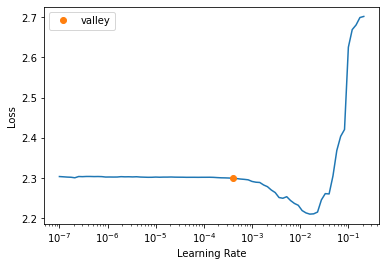

In [12]:
#Create learner for ReLU model
ReLU_learner = Learner(training_dataloader, ReLUModel, metrics = accuracy)
#Graph learning rates - plot the minimum, steep, valley, and slide
ReLU_optimal_lr = ReLU_learner.lr_find()
print(ReLU_optimal_lr)

In [ ]:
#Extract optimal learning rate for relu model
float_rlu_optimal_lr = ReLU_optimal_lr[0]
#Fit and train model
epochs = 10
#Callback at the end produces graph of loss
ReLU_learner.fine_tune(epochs, float_rlu_optimal_lr, cbs = [ShowGraphCallback()])

In [50]:
#Save model
ReLU_learner.save("ReLU_Model")

Path('models/ReLU_Model.pth')

TRAINING MAXOUT MODEL

SuggestedLRs(valley=0.00019054606673307717)


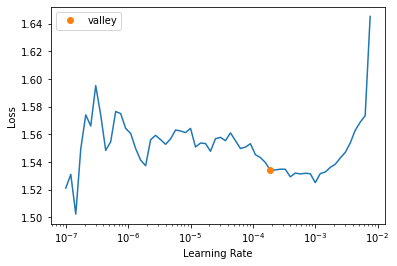

In [17]:
#Create learner object
Maxout_learner = Learner(training_dataloader, CustomMaxoutModel, metrics = "accuracy", cbs = [ShowGraphCallback()])
#Find ideal learning rate
maxout_optimal_lr = Maxout_learner.lr_find()
print(maxout_optimal_lr)

EPOCH [1] TRAINING LOSS: 0.5256696618199348
VALIDATION LOSS: 0.2491603061556816
EPOCH [2] TRAINING LOSS: 0.43470029398798943
VALIDATION LOSS: 0.23990259632468225
EPOCH [3] TRAINING LOSS: 0.3959623582363129
VALIDATION LOSS: 0.16180203594267367
EPOCH [4] TRAINING LOSS: 0.3541349661052227
VALIDATION LOSS: 0.14641845367848874
EPOCH [5] TRAINING LOSS: 0.329566614061594
VALIDATION LOSS: 0.1677621366083622
EPOCH [6] TRAINING LOSS: 0.30408419281989335
VALIDATION LOSS: 0.13576995819807053
EPOCH [7] TRAINING LOSS: 0.3014433953166008
VALIDATION LOSS: 0.13956392489373684
EPOCH [8] TRAINING LOSS: 0.2820170666128397
VALIDATION LOSS: 0.1215510043501854
EPOCH [9] TRAINING LOSS: 0.2720215394943953
VALIDATION LOSS: 0.1057022612169385
EPOCH [10] TRAINING LOSS: 0.2549172022640705
VALIDATION LOSS: 0.125324275046587


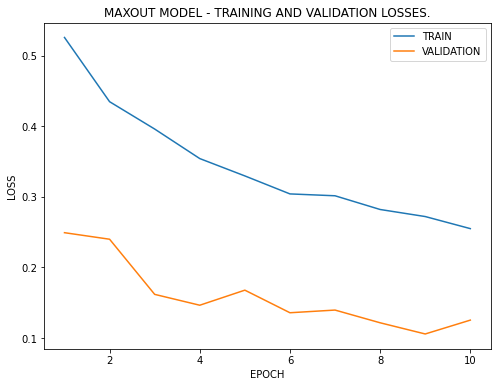

In [76]:
#Begin training fastai learner
#One of the key benefits of fastai is customization. As we have a custom activation function, some Recorder functionality in the fastai library does not work as intended.
#To solve this, we can write our own training loop in native PyTorch.

#Import matplotlib to display training graph and update as epochs progress
import matplotlib.pyplot as plt
%matplotlib inline

#Use optimal learning rate
float_mx_optimal_lr = maxout_optimal_lr[0]
#Define optimizer - ADAM, same as previous model to control for variables
Maxout_learner.opt = Adam(Maxout_learner.parameters(), float_mx_optimal_lr)

#Train model function
def train_model(learner, n_epochs, train_iters, valid_iters):
    #Train losses
    train_losses = []
    #Validation losses
    valid_losses = []
    #Array of epochs (for plotting the graph at the end of training)
    epochs = []

    #Iterate over epochs
    for epoch in range(n_epochs):
        #Iterate over each "minibatch" in batch (each sample in batch, batch size declared while we were using the dataloader)
        #This is for TRAINING data
        train_loop(learner, train_iters, train_losses, epoch, epochs)
        #Same process but with validation data and WITHOUT computing gradients
        valid_loop(learner, valid_iters, valid_losses)
    
    #If we are on the last epoch, return the average loss for the entire training session and create a graph of training and validation losses
    if epoch == n_epochs - 1:
        #Change figure size
        plt.figure(figsize = (8, 6))
        #Plot train and validation losses
        plt.plot(epochs, train_losses, label = "TRAIN")
        plt.plot(epochs, valid_losses, label = "VALIDATION")
        #Set titles
        plt.xlabel("EPOCH")
        plt.ylabel('LOSS')
        plt.title("MAXOUT MODEL - TRAINING AND VALIDATION LOSSES.")
        #Create a legend and show graph
        plt.legend()
        plt.show()

#Train loop for a single epoch
def train_loop(learner, train_iters, train_losses, epoch, epochs):
    #Set training epoch loss to zero
    train_epoch_loss = 0.0
    #Iterate over training data
    for batch_index, batch_data in enumerate(learner.dls.train, 0):
        #Get data inputs and labels
        data_inputs, data_labels = batch_data
        #Set gradient to zero
        learner.zero_grad()
        #Make predictions (learner.model)
        preds = learner.model(data_inputs)
        #Calculate loss
        calc_loss = learner.loss_func(preds, data_labels)
        #Calculate gradients
        calc_loss.backward()
        #Use gradients to take a "step" with the optimizer - optimizer is, by default, set to Adam
        learner.opt.step()
        #Append loss - .item() converts scalar to regular float
        train_epoch_loss += calc_loss.item()
        #Check if we are on the last iteration of the minibatch
        if batch_index == train_iters - 1:
            avg_epoch_loss = train_epoch_loss/train_iters
            train_losses.append(avg_epoch_loss)
            epochs.append(epoch + 1)
            print("EPOCH [{}] TRAINING LOSS: {}".format(epoch + 1, avg_epoch_loss))
            #Stop the loop 
            break

#Validation loop for a single epoch
def valid_loop(learner, valid_iters, valid_losses):
    #Set validation loss to zero
    valid_epoch_loss = 0.0
    #Iterate over validation samples
    for valid_batch_index, valid_batch_data in enumerate(learner.dls.valid, 0):
        #Get x inputs and y labels
        valid_inputs, valid_labels = valid_batch_data
        #Get predictions
        val_preds = learner.model(valid_inputs)
        #Calculate validation loss
        val_loss = learner.loss_func(val_preds, valid_labels)
        #Append loss
        valid_epoch_loss += val_loss.item()
        #If on the last iteration of minibatch, print loss and save best model
        if valid_batch_index == valid_iters - 1:
            avg_val_loss = valid_epoch_loss/valid_iters
            valid_losses.append(avg_val_loss)
            print("VALIDATION LOSS: {}".format(avg_val_loss))

#Train the model
train_model(learner = Maxout_learner, n_epochs = 10, train_iters = 500, valid_iters = 50)

In [93]:
#Save Maxout model
Maxout_learner.save("Maxout_Model")

Path('models/Maxout_Model.pth')

COMPARING PERFORMANCE

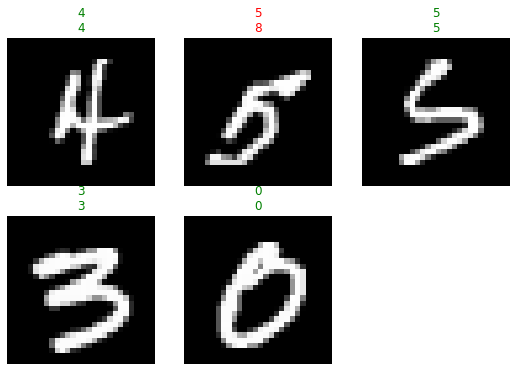

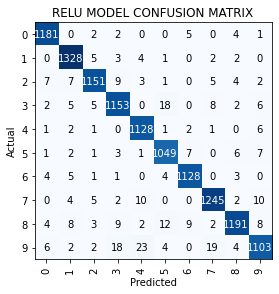

In [51]:
#Evaluate RELU and plot confusion matrix
evaluation_information = ClassificationInterpretation.from_learner(ReLU_learner)
#First, show some sample results (5 in total)
evaluation_information.show_results(idxs = [1, 2, 3, 4, 5])
#Then, plot a confusion matrix
evaluation_information.plot_confusion_matrix(title = "RELU MODEL CONFUSION MATRIX")

In [5]:
#Load both models (learner object is being created to avoid running all previous training and lr_find cells)
ReLU_learner = Learner(training_dataloader, ReLUModel, metrics = accuracy)
ReLU_learner.load("ReLU_Model")

Maxout_learner = Learner(training_dataloader, CustomMaxoutModel, metrics = "accuracy", cbs = [ShowGraphCallback()])
Maxout_learner.load("Maxout_Model")

In [24]:
#Define new datablock for validation data - to create a new dataloader for testing
#Set splitter and transforms to None as we do not want to split or augment the dataset

validationDatablock = DataBlock(
            blocks = (ImageBlock, CategoryBlock),
            get_items = get_image_files,
            splitter = None,
            get_y = parent_label,
            batch_tfms = None)

#Create new dataloader -> set shuffle to false and do not drop the last batch
valid_data = datablock.dataloaders(dataset/"testing", batch_size = 64, shuffle_train = False, drop_last = False)
#Use .train to access testing images -> this is simply as the testing images have been shuffled into the .train directory via fastai by default
#Use .tee to create 2 ITERATORS - one for testing each model
import itertools
ReLU_valid_loader, Maxout_valid_loader = itertools.tee(valid_data.train, 2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [25]:
#Evaluate perfromance based on 8000 samples from validation dataset (obtained from training dataloader)
#A seperate test set in this case is not required; gradients were off during validation and thus the model did not "learn" during those portions

#Use sci-kit learn to generate a confusion matrix and seaborn to plot 
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Declare true and prediction arrays for both models
relu_y_true = []
relu_y_preds = []
maxout_y_true = []
maxout_y_preds = []

#TensorImages (found in the dataloader) are a custom FastAi datatype that have no equivalent to .index - this functionality is needed to extract categories from predictions
#This function simply iterates and returns the needed index; as it will only be iterating over 10 samples this is sufficient 
def findTensorImageIndex1D(tensor, val):
    for i, obj in enumerate(tensor):
        if obj == val:
            return i

#Generate prediction and label array - for determining accuracy and plotting confusion matrix
def generatePredictions(learner, y_true, y_preds, validation_data):
    #This loop iterates over each batch, feeds to the model, and generates labels and predictions
    #As we require 8000 validation samples per learner, this loop must be executed (8000/64) 125 times
    for i in range(125):
        #Gets one BATCH (size 64) of inputs and labels
        inputs, labels = next(validation_data)
        #Add labels to y_true
        y_true.extend([*labels])
        #Passes one batch into Maxout model and obtains predictions
        predictions = learner.model(inputs)
        #Converts predictions into categories -> predictions are continous and thus must be processed to get categories
        for pred_distribution in predictions:
            pred_class = findTensorImageIndex1D(pred_distribution, max(pred_distribution))
            y_preds.append(pred_class)

generatePredictions(Maxout_learner, maxout_y_true, maxout_y_preds, Maxout_valid_loader)
generatePredictions(ReLU_learner, relu_y_true, relu_y_preds, ReLU_valid_loader)

Text(156.5, 0.5, 'ACTUAL VALUES')

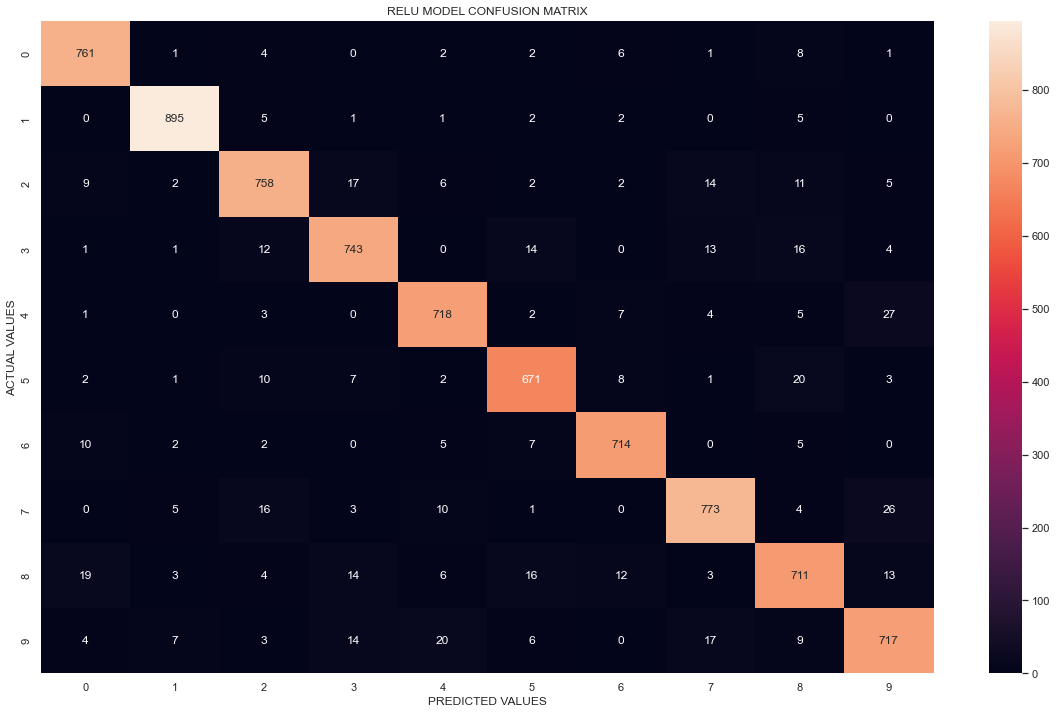

In [29]:
#Generate heatmap for ReLU model based on predictions and labels
ReLU_confusion_matrix_tensor = confusion_matrix(relu_y_true, relu_y_preds)
ReLU_heatmap = sns.heatmap(ReLU_confusion_matrix_tensor, annot = True, fmt = 'g')
sns.set(rc = {'figure.figsize':(20, 12)})
ReLU_heatmap.set_title("RELU MODEL CONFUSION MATRIX")
ReLU_heatmap.set_xlabel("PREDICTED VALUES")
ReLU_heatmap.set_ylabel("ACTUAL VALUES")

Text(156.5, 0.5, 'ACTUAL VALUES')

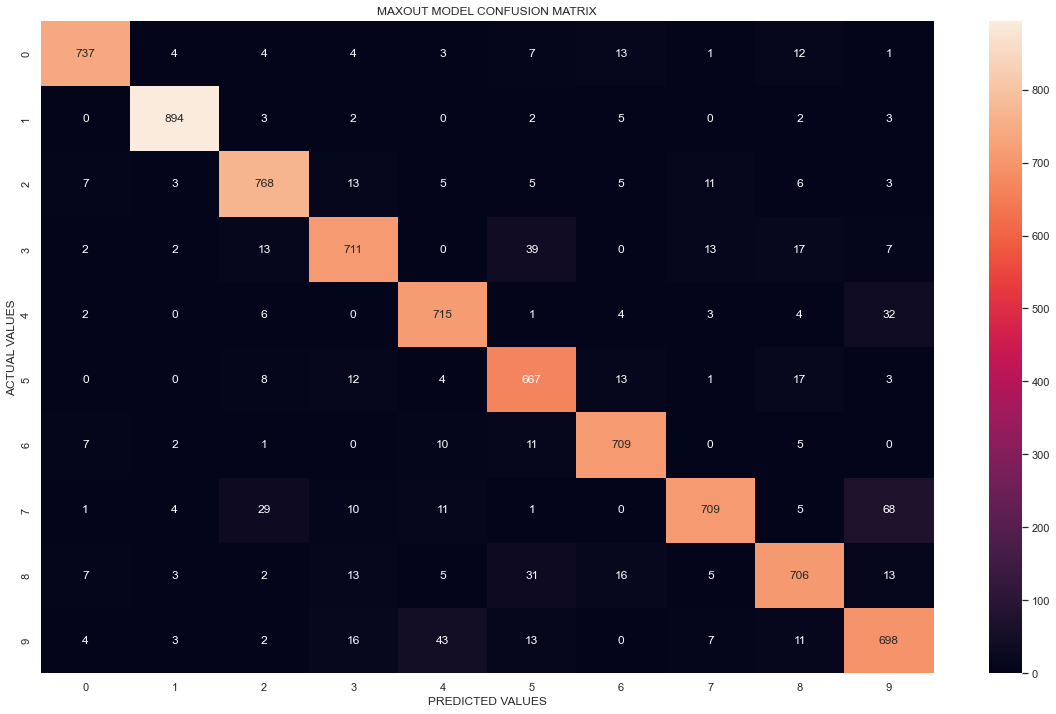

In [30]:
#Generate heatmap for Maxout model 
maxout_confusion_matrix_tensor = confusion_matrix(maxout_y_true, maxout_y_preds)
maxout_heatmap = sns.heatmap(maxout_confusion_matrix_tensor, annot = True, fmt = 'g')
# sns.set(rc = {'figure.figsize':(20, 12)})
maxout_heatmap.set_title("MAXOUT MODEL CONFUSION MATRIX")
maxout_heatmap.set_xlabel("PREDICTED VALUES")
maxout_heatmap.set_ylabel("ACTUAL VALUES")

In [34]:
#Define accuracy function
def get_accuracy(labels, preds):
    total_correct = 0
    #Find number of correct predictions
    [total_correct := total_correct + 1 for label, pred in zip(labels, preds) if label == pred]
    #Find accuracy
    accuracy = total_correct/len(labels)
    return accuracy

#Get accuracy of both models
ReLU_accuracy = get_accuracy(relu_y_true, relu_y_preds)
Maxout_accuracy = get_accuracy(maxout_y_true, maxout_y_preds)

#Print
print("RELU MODEL ACCURACY:", ReLU_accuracy)
print("CUSTOM MAXOUT MODEL ACCURACY:", Maxout_accuracy)

RELU MODEL ACCURACY: 0.932625
CUSTOM MAXOUT MODEL ACCURACY: 0.91425
